# YOLOV4 OBJECT DETECTION

### STEP 1: DARKNET CLONE AND INSTALLATION

In [ ]:
#!unzip -d /content/drive/MyDrive /content/drive/MyDrive/yolov4.zip

In [ ]:
#!zip -r /content/gdrive/MyDrive/yolov4.zip /content/gdrive/MyDrive/yolov4

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile  #I will use opencv library in darknet
!sed -i 's/GPU=0/GPU=1/' Makefile #I will use cpu library in darknet
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile #cudnn a necessary tool for cpu
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

### STEP 2: LOADING THE DATASET WE HAVE PREPARED

In [ ]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
#%cd darknet/
!ls /content/drive/MyDrive/yolov4

In [7]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /content/drive/MyDrive/yolov4/obj.zip ../
!cp /content/drive/MyDrive/yolov4/test.zip ../

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

### **STEP 3: LET'S PREPARE THE REQUIRED FILES FOR THE TRAINING**

In this step, we will create the .cfg file, obj.data, obj.names and train.txt files required for the training.

download cfg to google drive and change its name                         
```
from shutil import copy2                                    
copy2("/content/darknet/cfg/yolov4-custom.cfg","/content/drive/MyDrive/yolov4")    
```      
you can also copy like this


In [ ]:
# download cfg to google drive and change its name
#%cd darknet/
#!cp cfg/yolov4-custom.cfg /content/drive/MyDrive/yolov4/yolov4-obj.cfg

Changes we need to make in our config file:

(The values given here are the recommended values for these variables.)

1. The batch value in our config file is the number of images we will import into our convolutional neural network in each iteration. Subdivision determines how many subdivisions we will divide each batch into. We can set the subdivision value to 16. **batch = 64 and subdivision 16.** Subdivision=8 -> Split batch into 8 mini-batches so 64/8 = 8 images per mini-batch and these 8 images are sent to the GPU for processing. This process will be performed 8 times until the batch is completed and a new iteration will start with 64 new images.
If you are using a GPU where the RAM is low, set a higher value for subdivisions ( 32 or 64). This will obviously take longer to train since we are reducing the number of images being loaded and also the number of mini-batches.
If you have a GPU with good RAM, set a lower value for subdivisions (16 or 8). This will speed up the training process as this loads more images per iteration.

2. Then we can change the image size that will enter the model from the width and height sections. The max_batches value determines how many iterations our model will take. We can set our class number to x2000. Since we will train a model consisting of one class, we set the Max_batches value to 6000. **We equalize max_batches(2000 x number of classes trained). But the minimum we can do is 6000, so if you have one, two and three classes, it should be 6000.**

3. Then we change the value of the step to 80% or 90% of our max_batches value. I set the value of the step to 4800 which is 80% of 6000. **We make the values of the steps (80% of max_batches), (90% of max_batches).**

4. We replace the classes values under the [yolo] heading with the number of classes we train.

5. The Steps parameter is the number of iterations that the learning rate will be reduced to fit our model well. Finally, in our config file, we set the value of the class parameters to 3, which is our class number. We change the Filters parameters to (class + 5)x3. **In our case, this value is 18. We also equalize the filter's variables (number of classes to train + 5 )x3.**

In [9]:
# upload the custom .cfg back to cloud VM from Google Drive

!cp /content/drive/MyDrive/yolov4/yolov4-obj.cfg ./cfg

**-obj.names and obj.data**

Let's create a file named obj.names in our folder named yolov3 and write the names of your objects that we will train the file with.

E.G:
```
traffic sign
traffic light
```

In the same folder, we create a file with the name obj.data and write the directory where we will save the number of objects we will train, the addresses of the files named train.txt, text.txt and obj.names that we will use while training, and the weights we find as a result of the training.

E.G:
```
classes = 1
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = /mydrive/yolov4/backup
```


upload the obj.names and obj.data files to cloud VM from Google Drive

In [10]:
!cp /content/drive/MyDrive/yolov4/obj.names ./data
!cp /content/drive/MyDrive/yolov4/obj.data  ./data

#### **-Train and Test Files**


**generate_train.py**



```
  import os
  image_files = []
  os.chdir(os.path.join("data", "obj"))
  for filename in os.listdir(os.getcwd()):
      if filename.endswith(".jpg"):
          image_files.append("data/obj/" + filename)
  os.chdir("..")
  with open("train.txt", "w") as outfile:
      for image in image_files:
          outfile.write(image)
          outfile.write("\n")
      outfile.close()
  os.chdir("..")
```

**generate_test.py**



```
  import os

  image_files = []
  os.chdir(os.path.join("data", "test"))
  for filename in os.listdir(os.getcwd()):
      if filename.endswith(".jpg"):
          image_files.append("data/test/" + filename)
  os.chdir("..")
  with open("test.txt", "w") as outfile:
      for image in image_files:
          outfile.write(image)
          outfile.write("\n")
      outfile.close()
  os.chdir("..")
```


upload the generate_train.py and generate_test.py script to cloud VM from Google Drive


In [11]:
!cp /content/drive/MyDrive/yolov4/generate_train.py ./
!cp /content/drive/MyDrive/yolov4/generate_test.py ./

In [12]:
!python generate_train.py
!python generate_test.py

In [ ]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

### STEP 4: REDUCE THE WEIGHTS OF PRE-TRAINED CONVOLUTIONAL LAYERS

In this step, we download the used deep learning layers weights for the pre-trained yolov3. We do not have to perform this step, but starting the training with these weights will help the model we train to work more accurately and shorten the training time.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

### STEP 5: TRAINING
All the necessary files are ready, we can start the training.

Training will begin with the next command.

The duration of our training may vary depending on factors such as the number of photos in your data set, the quality of the photos, and the number of objects you train. Our loss value is important for the accuracy of our model. The lower our Loss value, the more accurate our model will work. We can run our model until the loss value stops decreasing and train the most accurate model possible according to our data set.

In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# the graph of our training.
imShow('chart.png')

If we don't like the weights, we can continue the training from where we left off.

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights -dont_show

### STEP 6: USE OUR TRAINED MODEL


Our training is complete, now we can make recognition on the photos we want.

Let's look at the average loss value and percent accuracy of our model

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights

#### **Let's run our model**

Let's test our model for a single image

In [14]:
# define helper functions
def imShow(path): 
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [15]:
cp /content/drive/MyDrive/yolov4/test_pred.zip ../

In [ ]:
%cd /content

In [ ]:
!unzip /content/test_pred.zip 

In [ ]:
%cd /content/darknet/

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

To predict and see individual images

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /content/test_pred/510256_cfc_002219.jpg -ext_output -dont_show -out  result.json -thresh 0.3 
imShow('predictions.jpg')

### **STEP 7: PREDICTION WITH TEST DATASET**

In [89]:
cp /content/drive/MyDrive/yolov4/test_pred.zip ../

In [ ]:
%cd /content

In [ ]:
!unzip /content/test_pred.zip 

In [ ]:
%cd /content/darknet/

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

In [94]:
!cp /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights ../

In [95]:
import glob
import os
image_path="../test_pred"
image_path_list = glob.glob(os.path.join(image_path, '*'))
image_path_list.sort()


In [96]:

def detectionPredict(imageDir):
    import glob
    import os
    import cv2
    os.system("./darknet detector test data/obj.data cfg/yolov4-obj.cfg ../yolov4-obj_last.weights {} -thresh 0.3".format(imageDir))

  

In [ ]:
#import torch.nn as nn
#import torch.optim as optim
from constant import *
import tqdm
import torch
from preprocessing import tensorize_image, tensorize_mask, image_mask_check
import cv2
from train import *
from PIL import Image



for i in tqdm.tqdm(range(len(image_path_list))):
    batch_test = image_path_list[i:i+1]
    detectionPredict(batch_test[0])
    img=cv2.imread("predictions.jpg")
    predict_name=batch_test[0]
    predict_path=predict_name.replace('test_pred', 'predict_sign')
    cv2.imwrite(predict_path,img.astype(np.uint8))



In [ ]:
!zip -r predict_sign.zip /content/predict_sign
!cp predict_sign.zip /content/drive/MyDrive/predicts

### **STEP 8: Multi class prediction**

**Predict from freespace, line and sign models**

In [19]:
cp /content/drive/MyDrive/yolov4/test_pred.zip ../

In [ ]:
%cd /content

In [ ]:
!unzip /content/test_pred.zip 

In [ ]:
%cd /content/darknet/

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

In [ ]:
!cp /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights ../

In [ ]:
import glob
import os
image_path="../test_pred"
image_path_list = glob.glob(os.path.join(image_path, '*'))
image_path_list.sort()


In [ ]:

def detectionPredict(imageDir):
    import glob
    import os
    import cv2
    os.system("./darknet detector test data/obj.data cfg/yolov4-obj.cfg ../yolov4-obj_last.weights {} -thresh 0.3".format(imageDir))

  

In [ ]:
#import torch.nn as nn
#import torch.optim as optim
from constant import *
import tqdm
import torch
from preprocessing import tensorize_image, tensorize_mask, image_mask_check
import cv2
from train import *
from PIL import Image



model_freespace= torch.load('/content/drive/MyDrive/models/Unet_1.pt')

model_line=torch.load('/content/drive/MyDrive/models/best_line_model.pt',map_location='cuda:0')
model_freespace=model_freespace.eval()
model_line=model_line.eval()
input_shape=(224,224)
cuda=True
if cuda:
    model_line = model_line.cuda()
    model_freespace=model_freespace.cuda()


for i in tqdm.tqdm(range(len(image_path_list))):
    batch_test = image_path_list[i:i+1]
    detectionPredict(batch_test[0])
    img=cv2.imread("predictions.jpg")

    test_input_line = tensorize_image(batch_test, input_shape, cuda)
    test_input_freespace=tensorize_image(batch_test, input_shape, cuda)

    outs_freespace = model_freespace(test_input_freespace)
    outs_line = model_line(test_input_line)

    out_freespace=torch.argmax(outs_freespace,axis=1)
    out_line=torch.argmax(outs_line,axis=1)

    out_freespace_cpu = out_freespace.cpu()
    out_line_cpu=out_line.cpu()

    outputs_list_freespace=out_freespace_cpu.detach().numpy()
    outputs_list_line=out_line_cpu.detach().numpy()

    mask_freespace=np.squeeze(outputs_list_freespace,axis=0)
    mask_line=np.squeeze(outputs_list_line,axis=0)

    mask_uint8_line = mask_line.astype('uint8')
    mask_uint8_freespace = mask_freespace.astype('uint8')
    
    mask_line= cv2.resize(mask_uint8_line, ((img.shape[1]), (img.shape[0])),interpolation=cv2.INTER_NEAREST)
    mask_freespace= cv2.resize(mask_uint8_freespace, ((img.shape[1]), (img.shape[0])),interpolation=cv2.INTER_CUBIC)
        

 
    mask_ind   = mask_line == 1
    mask_ind   = mask_freespace == 1
    cpy_img  = img.copy()
    
    img[mask_freespace==1,:] = (255, 0, 125)


    img[mask_line==1,:]=(0, 0, 255)
    img[mask_line==2,:]=(38, 255, 255)
    
    
    opac_image=(img/2+cpy_img/2).astype(np.uint8)
    predict_name=batch_test[0]
    predict_path=predict_name.replace('test_pred', 'full_predict')
    cv2.imwrite(predict_path,opac_image.astype(np.uint8))



In [ ]:
!zip -r predict_full.zip /content/full_predict
!cp predict_full.zip /content/drive/MyDrive/predicts

### **STEP 9: MULTI CLASS DETECTION IN VIDEO DATA**

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights -dont_show /content/drive/MyDrive/video/videoplayback_3.mp4 -thresh 0.2 -i 0 -out_filename /content/drive/MyDrive/video/results3.avi

In [ ]:
import cv2
# Opens the Video file
cap = cv2.VideoCapture('/content/drive/MyDrive/video/results3.avi')
i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('frames/kang'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [ ]:
#import torch.nn as nn
#import torch.optim as optim
import os
from constant import *
import glob
import tqdm
import torch
import numpy as np
from preprocessing import tensorize_image, tensorize_mask, image_mask_check
import cv2
from PIL import Image
model_freespace= torch.load('/content/drive/MyDrive/models/Unet_1.pt')

model_line=torch.load('/content/drive/MyDrive/models/best_line_model.pt',map_location='cuda:0')
model_freespace=model_freespace.eval()
model_line=model_line.eval()
input_shape=(224,224)
cuda=True
if cuda:
    model_line = model_line.cuda()
    model_freespace=model_freespace.cuda()

image_path="/content/frames"
image_path_list = glob.glob(os.path.join(image_path, '*'))
image_path_list.sort()

for i in tqdm.tqdm(range(len(image_path_list))):
    batch_test = image_path_list[i:i+1]
    img=cv2.imread(batch_test[0])

    test_input_line = tensorize_image(batch_test, input_shape, cuda)
    test_input_freespace=tensorize_image(batch_test, input_shape, cuda)

    outs_freespace = model_freespace(test_input_freespace)
    outs_line = model_line(test_input_line)

    out_freespace=torch.argmax(outs_freespace,axis=1)
    out_line=torch.argmax(outs_line,axis=1)

    out_freespace_cpu = out_freespace.cpu()
    out_line_cpu=out_line.cpu()

    outputs_list_freespace=out_freespace_cpu.detach().numpy()
    outputs_list_line=out_line_cpu.detach().numpy()

    mask_freespace=np.squeeze(outputs_list_freespace,axis=0)
    mask_line=np.squeeze(outputs_list_line,axis=0)

    mask_uint8_line = mask_line.astype('uint8')
    mask_uint8_freespace = mask_freespace.astype('uint8')

    mask_line= cv2.resize(mask_uint8_line, ((img.shape[1]), (img.shape[0])),interpolation=cv2.INTER_NEAREST)
    mask_freespace= cv2.resize(mask_uint8_freespace, ((img.shape[1]), (img.shape[0])),interpolation=cv2.INTER_CUBIC)



 
    mask_ind   = mask_line == 1
    mask_ind   = mask_freespace == 1
    cpy_img  = img.copy()
    
    img[mask_freespace==1,:] = (255, 0, 125)


    img[mask_line==1,:]=(0, 0, 255)
    img[mask_line==2,:]=(38, 255, 255)
    
    
    opac_image=(img/2+cpy_img/2).astype(np.uint8)
    predict_name=batch_test[0]
    predict_path=predict_name.replace('frames', 'full_predict')
    cv2.imwrite(predict_path,opac_image.astype(np.uint8))

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
from natsort import natsorted

pathIn= '/content/frames/'
pathOut = '/content/predict_video/video24.avi'
fps = 24
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files = natsorted(files)
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [ ]:
!cp /content/predict_video/video24.avi /content/drive/MyDrive/video

# CLASSIFICATION

In [14]:
# define helper functions
def imShow(path): 
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [31]:
cp /content/drive/MyDrive/yolov4/test_pred.zip ../

In [ ]:
%cd /content

In [ ]:
!unzip /content/test_pred.zip 

In [34]:
!cp /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights ../

In [ ]:
%cd /content/darknet/

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

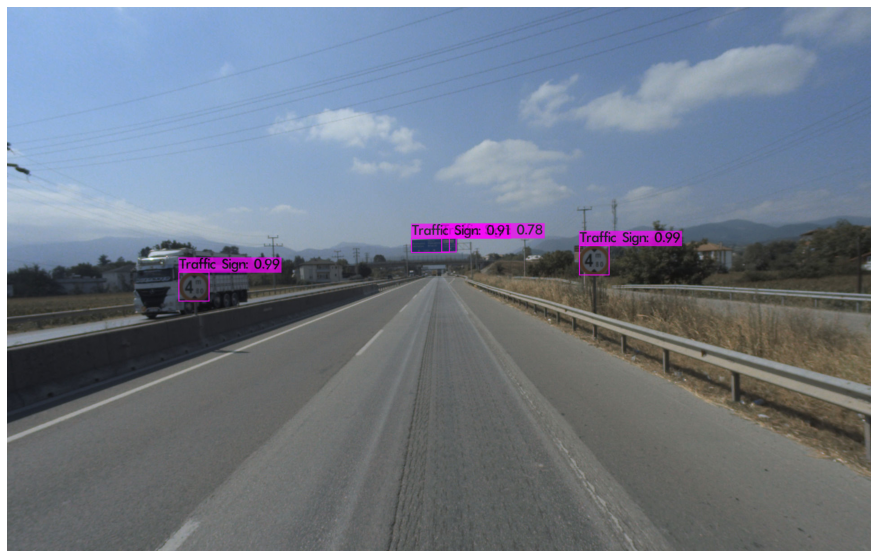

In [47]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/yolov4/backup/yolov4-obj_last.weights  /content/test_pred/510256_cfc_002219.jpg -ext_output -dont_show -out  result.json -thresh 0.3 
imShow('predictions.jpg')

#### STEP1: CROP_SIGN

In [87]:
import json

json_file = open('/content/darknet/result.json', 'r')#file reading process
json_dict=json.load(json_file)#Contents of json file converted to dict data type
i=0
img= cv2.imread(json_dict[0]["filename"])
for i,obj in enumerate(json_dict[0]["objects"]):
  if obj['class_id'] ==0:
    import cv2
    center_x=img.shape[1]*obj["relative_coordinates"]['center_x']
    center_y=img.shape[0]*obj["relative_coordinates"]['center_y']
    width=img.shape[1]*obj["relative_coordinates"]['width']
    height=img.shape[0]*obj["relative_coordinates"]['height']

    #x_center=int(xmin + width()/2)
    #y_center=int(ymin + height()/2)

    new_width=(img.shape[1]*obj["relative_coordinates"]['width'])/2
    new_height=(img.shape[0]*obj["relative_coordinates"]['height'])/2

    x_min=center_x-new_width
    y_min=center_y-new_height

    #width=int(xmax-xmin)
    #height=int(ymax-ymin)

    x_max=width+x_min
    y_max=height+y_min

    w=int(width)
    h=int(height)

    crop_img = img[int(y_min):int(y_min)+h,int( x_min):int(x_min)+w]
    ci_path=json_dict[0]["filename"].replace('test_pred','crop_image')
    cv2.imwrite(ci_path[:-4]+"-"+str(i)+".jpg",crop_img)
